### Project-01

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # визуалаизация циклов
import torch 
import torchvision 
from torch.utils.data import DataLoader
from torchvision import transforms


### Подготовка данных

In [167]:
# посмотрим что рядом
!ls

CV_project1_data.zip  data  sample_data


In [168]:
# распаковка модели
!unzip -o CV_project1_data.zip -d .

Archive:  CV_project1_data.zip
  inflating: ./data/train/bill_gates/006f6dcf-315f-4291-80d2-b61054210273.jpg  
  inflating: ./data/train/bill_gates/00715f3e-b281-4199-91c7-7da7a8475d7b.jpg  
  inflating: ./data/train/bill_gates/00a6f308-78d3-4ebc-b441-23aebc81ddff.jpg  
  inflating: ./data/train/bill_gates/00b4268f-0870-486c-98b0-9d13e6834525.jpg  
  inflating: ./data/train/bill_gates/011e2141-db98-43a5-ba17-2dbe3a7604c0.jpg  
  inflating: ./data/train/bill_gates/0121cf2a-33d3-425b-aca7-6a03de5cbd1e.jpg  
  inflating: ./data/train/bill_gates/01292fb3-5ed1-4f1b-8f3e-cbab05095b60.jpg  
  inflating: ./data/train/bill_gates/01333537-d705-4507-ba7f-04b6ba863850.jpg  
  inflating: ./data/train/bill_gates/016517ba-0d8d-46b3-8b34-0226b2ed4d6d.jpg  
  inflating: ./data/train/bill_gates/01d88f7d-fee5-4e94-a575-f5f4a5b67540.jpg  
  inflating: ./data/train/bill_gates/02022638-0c8d-4d0e-969d-2b129f4e706b.jpg  
  inflating: ./data/train/bill_gates/024f3d59-21f6-43fa-916e-203c5c27effe.jpg  
  inflati

In [169]:
# загрузка датасета
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder("./data/train/")
valid_dataset = ImageFolder("./data/valid/")

In [170]:
# посмотрим один
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=70x70 at 0x7F0CC09B1650>, 0)

In [171]:
# и размер
print(len(train_dataset))
print(len(valid_dataset))

3000
914


In [172]:
# пройдемся по набору данных с шагом 500
for i in range(0, len(train_dataset), 500):
    print(train_dataset.samples[i])


('./data/train/bill_gates/006f6dcf-315f-4291-80d2-b61054210273.jpg', 0)
('./data/train/bill_gates/9988e7f8-39c9-49e1-99c2-4d68e568c7d6.jpg', 0)
('./data/train/elon_musk/7efe6db3-061f-4850-b03e-841228a05d46.jpg', 1)
('./data/train/jeff_bezos/5808df03-ab8d-43cf-85e6-f8f4480a0949.jpg', 2)
('./data/train/mark_zuckerberg/4330dbea-f482-4ca9-b8a3-6beb318bc662.jpg', 3)
('./data/train/steve_jobs/22d92e6e-4df5-4025-8d6f-9f4b77b3b8f4.jpg', 4)


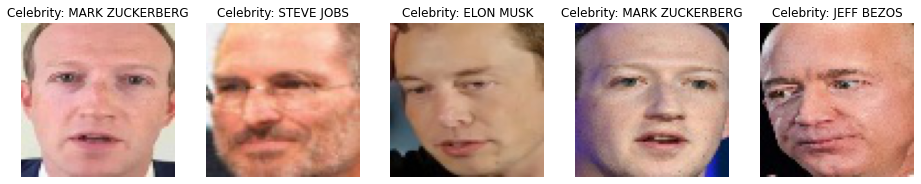

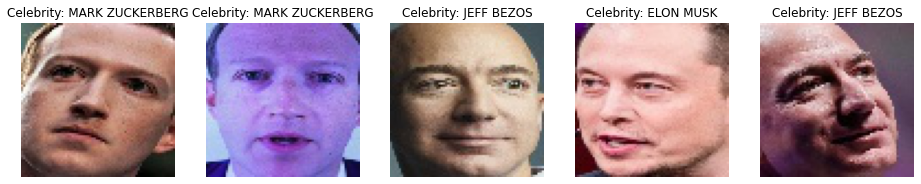

In [173]:
# визуализация части набора данных
import random

def plot_samples(dataset, num_samples=5):
    '''
    Печать примеров из набора данных
    dataset - набор данных
    num_samples=5 - количесво примеров
    '''
    
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title("Сelebrity: " + random_label.replace("_", " ").upper())
        axes[i].axis("off")

    plt.show()

plot_samples(train_dataset)
plot_samples(valid_dataset)



In [174]:
# преобразование набора данных
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset.transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    normalize
])

valid_dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [175]:
# оборачваем набор данных в загрузчик
import os

BATCH_SIZE = 16

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()
)

In [176]:
# пробежимся по загрузчику с визуализацией
for images, targets in tqdm(valid_loader):
    pass



100%|██████████| 58/58 [00:02<00:00, 24.40it/s]


### Обучение модели

In [177]:
def train_model(net, optimizer, train_dataset, valid_dataset, num_epochs=10):
    '''
    Функция обучения модели
    '''
    loss_train = []
    top1_train = []
    loss_valid = []
    top1_valid = []

    for epoch in range(num_epochs):
        # переключаем torch в режим сохрания данных для рассчета градиентов
        torch.set_grad_enabled(True)
        # переключаем модель в режим обучения для хранения промежуточной информация
        net.train()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(train_loader)):
            # переносим на GPU при возможности
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # делаем шаг обновления весов модели
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(np.mean(losses))
        top1_train.append(np.mean(equals))

        # для валидации градиенты не нужны
        torch.set_grad_enabled(False)
        # переключаем модель в режим валидации (быстрее, не храним ничего лишнего)
        net.eval()

        losses = []
        equals = []

        for i, (images, target) in enumerate(tqdm(valid_loader)):
            # переносим на GPU при возможности
            images = images.to(device)
            target = target.to(device)

            # считаем сырые предсказания и функцию потерь
            output = net(images)
            loss = criterion(output, target)

            # запоминаем функцию потерь и правильность предсказаний
            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            # шаг обновления весов здесь не нужен
            ...

        loss_valid.append(np.mean(losses))
        top1_valid.append(np.mean(equals))

    return loss_train, top1_train, loss_valid, top1_valid

In [178]:
# функция потерь для обучения классификации — кроссэнтропия
criterion = torch.nn.CrossEntropyLoss()

# для обучение возьмем легковесную из семейства ResNet модель ResNet-34:
net = torchvision.models.resnet34(pretrained=True)
# заморозим все слои модели
for parameter in net.parameters():
    parameter.requres_grad = False
# заменим классификатор на свой с нужным количесвом классов
net.fc = torch.nn.Linear(512, len(train_dataset.classes))
# если есть видеокарта, используем её
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

In [179]:
# в качестве оптимизатора используем SGD с параметрами по умолчанию для обучения ResNet.
optimizer = torch.optim.SGD(net.parameters(), lr=1e-3, weight_decay=1e-4)
# обучаем на 5 эпохах
loss_train, top1_train, loss_valid, top1_valid = train_model(net, optimizer, train_dataset, valid_dataset, 5)

100%|██████████| 58/58 [00:04<00:00, 13.99it/s]


### Анализ обученной модели

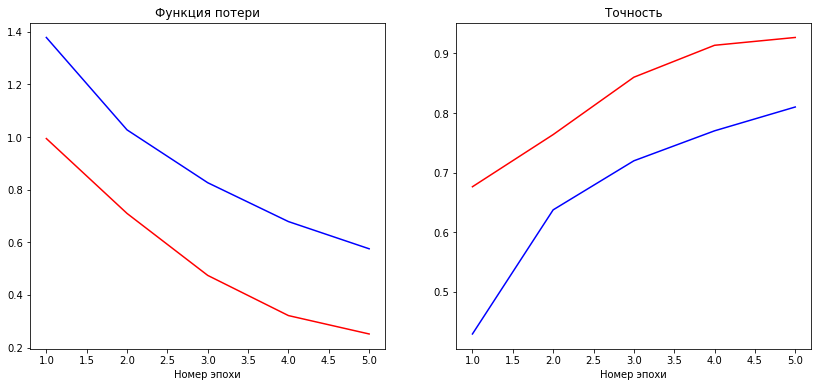

In [180]:
# визуализация процесса обучения
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Функция потери")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), top1_train, color="b")
plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Точность")

plt.show()

In [181]:
# точность по эпохам
top1_valid

[0.6761487964989059,
 0.7636761487964989,
 0.8599562363238512,
 0.9135667396061269,
 0.9266958424507659]

### Предсказание

720 ('./data/valid/mark_zuckerberg/dbfd521c-e217-4a45-b9c5-fa6fd9890cdf.jpg', 3)
mark_zuckerberg 3


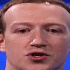

In [182]:
# берем случайный пример из набора валидации
i = random.randint(0, len(valid_dataset)-1)
print(i, valid_dataset.samples[i])
image = Image.open(valid_dataset.samples[i][0])

# далем из картинки тензор
tensor = valid_dataset.transform(image)
# и затем батч
batch = torch.stack([tensor])
# считаем
with torch.no_grad():
    output = net(batch.to(device)).to("cpu")
# выводим результат
predicted = output.argmax().item()
print(valid_dataset.classes[predicted], predicted)
image

### Другая сеть, для закрепления материала

In [183]:
# грузим альтернативную сеть
net = torchvision.models.mobilenet_v3_small(pretrained=True)
# морозим ее слои
for parameter in net.parameters():
    parameter.requres_grad = False

In [184]:
# смотрим её классификатор
net

MobileNetV3(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): ConvNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride

In [185]:
# менаем классификатор на свой с учета количества наших классов
net.classifier = torch.nn.Sequential(
    torch.nn.Linear(576, 1024, bias=True),
    torch.nn.Hardswish(),
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(1024, len(train_dataset.classes))                                     
)
# смотрим как получилось
net.classifier


Sequential(
  (0): Linear(in_features=576, out_features=1024, bias=True)
  (1): Hardswish()
  (2): Dropout(p=0.2, inplace=True)
  (3): Linear(in_features=1024, out_features=5, bias=True)
)

In [186]:
net = net.to(device)
# в качестве оптимизатора используем Адам, параметры по умолчанию
optimizer = torch.optim.Adam(net.parameters())
# обуение модели на 5 эпохах
loss_train, top1_train, loss_valid, top1_valid = train_model(net, optimizer, train_dataset, valid_dataset, 5)

100%|██████████| 58/58 [00:02<00:00, 21.62it/s]


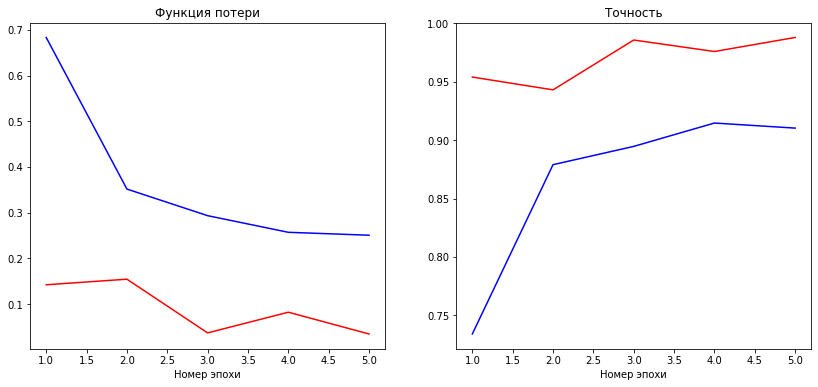

In [187]:
# визуализация процесса обучения
plt.figure(figsize=(14, 6))

plt.subplot(121)
plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Функция потери")

plt.subplot(122)
plt.plot(range(1, len(loss_train) + 1), top1_train, color="b")
plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r")
plt.xlabel("Номер эпохи")
plt.title("Точность")

plt.show()

In [188]:
# точность по эпохам
top1_valid

[0.9540481400437637,
 0.9431072210065645,
 0.9857768052516411,
 0.975929978118162,
 0.9879649890590809]

414 ('./data/valid/elon_musk/ffa47f2b-be2c-47b5-9aa4-54c839ce2baa.jpg', 1)
elon_musk 1


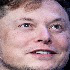

In [190]:
# проверка модели
i = random.randint(0, len(valid_dataset)-1)
print(i, valid_dataset.samples[i])
image = Image.open(valid_dataset.samples[i][0])

tensor = valid_dataset.transform(image)
batch = torch.stack([tensor])
with torch.no_grad():
    output = net(batch.to(device)).to("cpu")
predicted = output.argmax().item()
print(valid_dataset.classes[predicted], predicted)
image

### Выводы
* 5 эпох достаточно на 10 уже заметно переобучение
* Новые модели точнее
* Для проверки желательно выделить тестовый набор данных
